### A fuzzy-KNN Algorithm

One major issue classification algorithms face while extracting rules are giving equal importance to every sample in the dataset. The paper “A Fuzzy K-Nearest Neighbor Algorithm” by James M. Keller, Michael R. Gray, and James A. Givens, JR. introduces the theory of fuzzy sets and incorporates the fuzzy search techniques into the KNN algorithm. The fuzzy algorithm outperforms the generic KNN in terms of mistake rate and holds up well against more conventional, complex pattern recognition techniques. 
</br> </br>
The issue with the base KNN classifier is that each sample is given an equal weight. This creates issues in certain situations when sample sets overlap. Equal weight is given to typical vectors and the actual representatives of the cluster. Another issue is that when one of the vectors is classified, the membership strength cannot be determined. Hence the fuzzy set theory is introduced to combat all these issues

In [528]:
import operator
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

### Load the dataset

In [529]:
dataset = load_iris()
x = dataset.data
y = dataset.target

### Split the dataset into train and test

In [530]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, random_state=56, test_size=0.3)

### Fuzzy KNN

The fuzzy K-nearest neighbor algorithm assigns class membership to a sample vector rather than assigning the vector to a particular class. The advantage is that no arbitrary assignments are made by the algorithm. 

In [531]:
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, plot=False):
        self.k = k
        self.plot = plot
        
        
    def fit(self, X, y=None):
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        #Initialize the classes which we have to predict
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        #Create the dataframe 
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        #Get the fuzzy memberships for all the data points
        self.memberships = self._compute_memberships()
        #Update the memberships for all the data points
        self.df['membership'] = self.memberships
        
        self.fitted_ = True
        return self
    
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        y_pred = list()
        
        for x in X:
            #get the k nearest neighbours
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
            
            votes = dict()
            for c in self.classes:
                den = 0
                 # We iterate over all the neighbours and find its distance from current point
                for n in range(self.k):
                    dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                    den += 1 / (dist ** 2)
                #Once the distance is computed, sum of vote of neighbour determines the predicted class
                # each vote of a neighbour is calculated using the distance from point and the fuzzy membership of the predicted class 
                neighbors_votes = []
                for n in range(self.k):
                    dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                    num = (neighbors.iloc[n].membership[c]) / (dist ** 2)
                    
                    vote = num/den
                    neighbors_votes.append(vote)
                votes[c] = np.sum(neighbors_votes)
            #class with max votes is predicted   
            pred = max(votes.items(), key=operator.itemgetter(1))[0]
            y_pred.append((pred, votes))
            
        return y_pred

    def _find_k_nearest_neighbors(self, df, x):
         #find K nearest neighbours from point x (using euclidean distance)
        X = df.iloc[:,0:self.xdim].values
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        #Sort the points by distance for ease of computation later
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

                
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        #Count of each class in neighbours as a dictionary which will be used for voting
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        return counts
        
        
    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            #Get the k nearest neighbours and counts of each classes
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
            counts = self._get_counts(neighbors)

            #compute the membership of each class
            membership = dict()
            for c in self.classes:
                try:
                    #uci is the degree of membership of each vector in class 'classes'
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    #if no neighbours found
                    membership[c] = 0
                    
            memberships.append(membership)
        return memberships

### Comparing Fuzzy KNN with various values of K

In [532]:
analysis = {
    'K' : list(),
    'Training time' : list(),
    'Prediction time' : list(),
    'Accuracy' : list(),
    'AOC' : list()
}

In [533]:
def add_classifier(d):
    for i in analysis.keys():
        analysis[i].append(d[i])

### K = 5

In [534]:
fuzzyknn = FuzzyKNN(k = 5)
fuzzy_knn_classifier = {x : None for x in analysis.keys()}
fuzzy_knn_classifier['K'] = '5'
start_training_time = datetime.now()
fuzzyknn.fit(x_train, y_train)
end_training_time = datetime.now()
fuzzy_knn_classifier['Training time'] = (end_training_time - start_training_time).total_seconds()

start_prediction_time = datetime.now()
y_pred = fuzzyknn.predict(x_test)
end_prediction_time = datetime.now()
fuzzy_knn_classifier['Prediction time'] = (end_prediction_time - start_prediction_time).total_seconds()

print(y_pred)

y_actual_pred = list()
for (pred_class, fuzzy_membership_votes) in y_pred : 
    y_actual_pred.append(pred_class)
score = accuracy_score(y_test, y_actual_pred)
print(score)
fuzzy_knn_classifier['Accuracy'] = score


[(2, {0: 0.0, 1: 0.0, 2: 0.9999999999999999}), (1, {0: 0.0, 1: 1.0, 2: 0.0}), (1, {0: 0.0, 1: 0.526164956726085, 2: 0.4738350432739151}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (2, {0: 0.0, 1: 0.0, 2: 1.0000000000000002}), (0, {0: 0.9999999999999999, 1: 0.0, 2: 0.0}), (0, {0: 0.9999999999999999, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.053481259370314796, 2: 0.9465187406296854}), (1, {0: 0.0, 1: 1.0000000000000002, 2: 0.0}), (0, {0: 1.0000000000000002, 1: 0.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (0, {0: 0.9999999999999999, 1: 0.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.0, 2: 0.9999999999999999}), (1, {0: 0.0, 1: 1.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (1, {0: 0.0, 1: 0.9999999999999999, 2: 0.0}), (1, {0: 0.0, 1: 0.7723026356276801, 2: 0.22769736437231985}), (0, {0: 0.9999999999999998, 

The y_pred depicts the tuple - (predicted_class, fuzzy_membership_votes)
where predicted_class is the class predicted for the datapoint and fuzzy_membership_votes shows the votes given by each of the k nearest neighbour

### AOC Curve depicting false and true positive rates

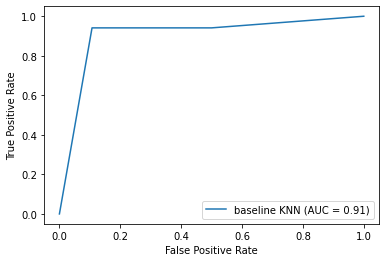

In [535]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_actual_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
fuzzy_knn_classifier['AOC'] = roc_auc
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='baseline KNN')
add_classifier(fuzzy_knn_classifier)
display.plot()
plt.show()

### K = 15

In [536]:
fuzzyknn = FuzzyKNN(k = 10)
fuzzy_knn_classifier = {x : None for x in analysis.keys()}
fuzzy_knn_classifier['K'] = '15'
start_training_time = datetime.now()
fuzzyknn.fit(x_train, y_train)
end_training_time = datetime.now()
fuzzy_knn_classifier['Training time'] = (end_training_time - start_training_time).total_seconds()

start_prediction_time = datetime.now()
y_pred = fuzzyknn.predict(x_test)
end_prediction_time = datetime.now()
fuzzy_knn_classifier['Prediction time'] = (end_prediction_time - start_prediction_time).total_seconds()

print(y_pred)

y_actual_pred = list()
for (pred_class, fuzzy_membership_votes) in y_pred : 
    y_actual_pred.append(pred_class)
score = accuracy_score(y_test, y_actual_pred)
print(score)
fuzzy_knn_classifier['Accuracy'] = score


[(2, {0: 0.0, 1: 0.004253465578507544, 2: 0.9957465344214924}), (1, {0: 0.0, 1: 1.0, 2: 0.0}), (2, {0: 0.0, 1: 0.47843255439461846, 2: 0.5215674456053815}), (2, {0: 0.0, 1: 0.006058756335239761, 2: 0.9939412436647602}), (2, {0: 0.0, 1: 0.0, 2: 1.0}), (2, {0: 0.0, 1: 0.005704119144122908, 2: 0.9942958808558768}), (2, {0: 0.0, 1: 0.0518338538632207, 2: 0.9481661461367795}), (0, {0: 0.9999999999999998, 1: 0.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.16348657101578615, 2: 0.836513428984214}), (1, {0: 0.0, 1: 1.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (0, {0: 1.0000000000000002, 1: 0.0, 2: 0.0}), (0, {0: 0.9999999999999999, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.048143873629858225, 2: 0.9518561263701417}), (0, {0: 0.9999999999999999, 1: 0.0, 2: 0.0}), (0, {0: 0.9999999999999998, 1: 0.0, 2: 0.0}), (0, {0: 1.0, 1: 0.0, 2: 0.0}), (2, {0: 0.0, 1: 0.005280132417113909, 2: 0.9947198675828862}), (1, {0: 0.0, 1: 1.0, 2: 0.0}), (0, {0: 1.0000000000000002, 1: 0.0, 2: 0.0}), (2, {0:

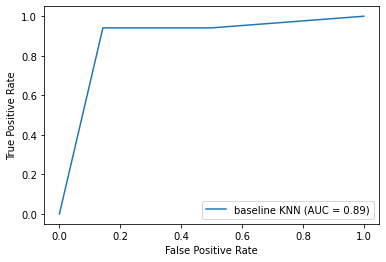

In [537]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_actual_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
fuzzy_knn_classifier['AOC'] = roc_auc
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='baseline KNN')
add_classifier(fuzzy_knn_classifier)
display.plot()
plt.show()

### K = 50

In [538]:
fuzzyknn = FuzzyKNN(k = 50)
fuzzy_knn_classifier = {x : None for x in analysis.keys()}
fuzzy_knn_classifier['K'] = '50'
start_training_time = datetime.now()
fuzzyknn.fit(x_train, y_train)
end_training_time = datetime.now()
fuzzy_knn_classifier['Training time'] = (end_training_time - start_training_time).total_seconds()

start_prediction_time = datetime.now()
y_pred = fuzzyknn.predict(x_test)
end_prediction_time = datetime.now()
fuzzy_knn_classifier['Prediction time'] = (end_prediction_time - start_prediction_time).total_seconds()

print(y_pred)

y_actual_pred = list()
for (pred_class, fuzzy_membership_votes) in y_pred : 
    y_actual_pred.append(pred_class)
score = accuracy_score(y_test, y_actual_pred)
print(score)
fuzzy_knn_classifier['Accuracy'] = score

[(2, {0: 0.0, 1: 0.2841094380254613, 2: 0.7158905619745392}), (1, {0: 0.20459514052993877, 1: 0.6953738431474441, 2: 0.10003101632261727}), (2, {0: 0.0, 1: 0.49832475581137836, 2: 0.5016752441886214}), (2, {0: 0.0, 1: 0.33229505340288845, 2: 0.6677049465971117}), (2, {0: 0.0, 1: 0.22670533647598998, 2: 0.7732946635240101}), (2, {0: 0.0, 1: 0.30399669102091365, 2: 0.6960033089790866}), (2, {0: 0.0, 1: 0.3991087646189429, 2: 0.6008912353810574}), (0, {0: 0.8534004371562034, 1: 0.1451864169032939, 2: 0.0014131459405027737}), (0, {0: 0.8551587796244379, 1: 0.1436975633139488, 2: 0.001143657061613572}), (2, {0: 0.0, 1: 0.4072175084346145, 2: 0.5927824915653853}), (1, {0: 0.0009090675159289458, 1: 0.8000441948415421, 2: 0.19904673764252906}), (0, {0: 0.85736382336343, 1: 0.14181595508324085, 2: 0.0008202215533296714}), (0, {0: 0.8592058900017641, 1: 0.14025208527405295, 2: 0.000542024724183051}), (0, {0: 0.8410508143064159, 1: 0.15564249525980425, 2: 0.0033066904337802276}), (2, {0: 0.0, 1: 

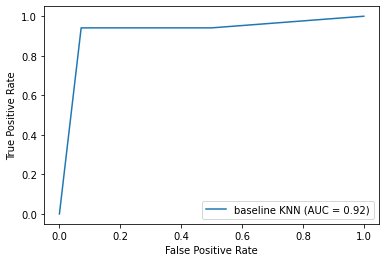

In [539]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_actual_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
fuzzy_knn_classifier['AOC'] = roc_auc
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='baseline KNN')
add_classifier(fuzzy_knn_classifier)
display.plot()
plt.show()

In [540]:
analysis_df = pd.DataFrame(analysis)
analysis_df

,K,Training time,Prediction time,Accuracy,AOC
0,5,0.364098,0.567126,0.911111,0.905462
1,15,0.392131,0.998609,0.888889,0.888655
2,50,0.461101,4.488000,0.933333,0.922269
